In [189]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [345]:
artists = pd.read_csv('data_by_artist.csv')
artists = artists.drop_duplicates(subset='artist_name', keep='last')
artists[80:90]

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
80,Neil Young,379125,0.511677,0.397089,0.494641,126.167687,-12.942327,1,7,0.460809,0.046176,0.256286,0.037686,254191.5612,38.605442,294
81,Julie London,247966,0.425233,0.188913,0.275022,106.086712,-14.608791,1,10,0.815055,0.006661,0.164768,0.047037,156406.7842,21.181507,292
82,Los Tigres del Norte,806336,0.753952,0.518852,0.893810,123.423041,-9.289872,1,9,0.379285,0.000155,0.163390,0.118937,186968.8241,43.720690,290
83,Stan Getz,742899,0.501307,0.237282,0.523630,113.312850,-16.695554,1,5,0.877871,0.313541,0.163593,0.047590,305771.3937,21.557491,287
84,Green Day,154544,0.403968,0.898068,0.656616,138.006135,-4.260135,1,1,0.018499,0.020255,0.196684,0.071501,204988.3381,47.925267,281
85,Marty Robbins,858710,0.578662,0.339302,0.547685,114.574801,-11.804406,1,4,0.799804,0.008368,0.183821,0.040553,180774.1922,25.245552,281
86,Bill Evans,61912,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
87,Bill Evans,74005,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
88,Bill Evans,764702,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
89,Bee Gees,43714,0.558565,0.510842,0.597418,107.119078,-11.204190,1,7,0.247674,0.046172,0.245669,0.039678,228251.3048,42.553903,269


In [129]:
years = pd.read_csv('data_by_year.csv')
years

,year,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity
0,1921,0.425661,0.236784,0.425495,100.397758,-17.095437,1,7,0.895823,0.322330,0.215814,0.077258,229911.9141,0.351562
1,1922,0.480000,0.237026,0.534056,101.376139,-19.179958,1,10,0.939236,0.440470,0.238647,0.115419,167904.5417,0.138889
2,1923,0.568462,0.246936,0.624788,112.456598,-14.373882,1,0,0.976329,0.401932,0.236656,0.098619,178356.3018,5.727811
3,1924,0.548654,0.347033,0.668574,120.653359,-14.202304,1,10,0.935575,0.583955,0.237875,0.090210,188461.6498,0.603376
4,1925,0.571890,0.264373,0.616430,115.671715,-14.516707,1,5,0.965422,0.408893,0.243094,0.115457,184130.6996,2.707224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016,0.599976,0.592877,0.430769,119.070344,-7.949913,1,0,0.280290,0.074646,0.180198,0.107298,219400.7638,61.371254
96,2017,0.612286,0.586739,0.414465,116.840277,-8.422697,1,1,0.289916,0.098209,0.194218,0.111752,209343.6130,64.861500
97,2018,0.664930,0.590591,0.447141,122.004325,-7.253666,1,1,0.271941,0.035948,0.171781,0.128140,200919.1190,67.276000
98,2019,0.644215,0.578796,0.465856,118.868163,-8.041738,1,1,0.289298,0.076518,0.167161,0.124799,197733.1330,69.655500


In [130]:
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in range(len(full)): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')
full

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored)
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103482,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster
103483,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love
103484,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese
103485,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster


In [132]:
influence = pd.read_csv('influence_data.csv')
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990
...,...,...,...,...,...,...,...,...
42765,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010
42766,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010
42767,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010
42768,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010


In [7]:
names = []
for i in artists['artist_name']:
    names.append(i)
influence = influence[influence['influencer_name'].isin(names)]
influence = influence[influence['follower_name'].isin(names)]
influence = influence.reset_index(drop=True)
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990
...,...,...,...,...,...,...,...,...
42747,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010
42748,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010
42749,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010
42750,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010


In [8]:
influenceGraph = nx.DiGraph()

In [9]:
i = 0
while i < len(influence):
    influencer = artists[artists['artist_name'] == influence['influencer_name'][i]]
    influencer = influencer[['energy','valence', 'key', 'acousticness', 'instrumentalness', 'speechiness']]
    v1 = influencer.to_numpy()
    follower = artists[artists['artist_name'] == influence['follower_name'][i]]
    follower = follower[['energy','valence', 'key', 'acousticness', 'instrumentalness', 'speechiness']]
    v2 = follower.to_numpy()
    weight = cosine_similarity(v1, v2) * 1000
    influenceGraph.add_edge(influence['influencer_name'][i], influence['follower_name'][i], weight = weight)
    i += 1

In [15]:
influenceGraph.nodes['Bob Dylan'].degree

AttributeError: 'dict' object has no attribute 'degree'

In [367]:
idDict = {}
for i in range(len(artists)):
    idDict[artists['artist_id'][i]] = artists['artist_name'][i]

influence = pd.read_csv('influence_data.csv')
iGraph = nx.DiGraph()
for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in range(len(influence)):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

arts = []
artnames = []
scores = []
for node in iGraph.nodes():
    children = list(iGraph.successors(node))
    total = 0
    for child in children:
        total += iGraph.out_degree[child]
        
    iGraph.nodes[node]['weight'] = total
    arts.append(node)
    try:
        artnames.append(idDict[node])
    except KeyError:
        artnames.append('Unknown')
    scores.append(total)
    
   
totalInfluence = pd.DataFrame({'names':artnames, 'artists':arts, 'scores':scores})
totalInfluence = totalInfluence.sort_values(by=['scores'], ascending = False)
totalInfluence[:20]

,names,artists,scores
15,The Beatles,754032,11237
4,Bob Dylan,66915,7928
5,The Rolling Stones,894465,6341
137,Chuck Berry,120521,5897
7,Elvis Presley,180228,4749
210,The Velvet Underground,840402,4380
176,Little Richard,824022,4371
147,Jimi Hendrix,354105,4312
201,Hank Williams,549797,4134
35,The Kinks,100160,4067


In [134]:
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence

,names,artists,scores
0,The Beatles,754032,11237
1,Bob Dylan,66915,7928
2,The Rolling Stones,894465,6341
3,Chuck Berry,120521,5897
4,Elvis Presley,180228,4749
...,...,...,...
5850,Wet Wet Wet,203765,0
5851,Des'ree,206668,0
5852,David Lindley,211146,0
5853,Vixen,222748,0


In [135]:
artistStyle = full.groupby(['artist_names']).mean() #some values dont make sense to average but w/ex
artistStyle

songStats = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']

for edge in list(iGraph.edges())[:100]: #could combine this w/weighted influence scores to see how much they actually influence
    inf = edge[0] #the musical style of the people theys upposedly influence 
    fol = edge[1]
    infstats = artistStyle[artistStyle['artists_id'] == inf][songStats]
    folstats = artistStyle[artistStyle['artists_id'] == fol][songStats]
    a = cosine_similarity(infstats, folstats)
    print(a)

[[0.91836107]]
[[0.96846749]]
[[0.99754292]]
[[0.94749496]]
[[0.97385075]]
[[0.6478513]]
[[0.9942241]]
[[0.74212613]]
[[0.98274307]]
[[0.86855959]]
[[0.99076241]]
[[0.95748195]]
[[0.90812649]]
[[0.80597076]]
[[0.98228294]]
[[0.84575681]]
[[0.98485552]]
[[0.99084487]]
[[0.95293218]]
[[0.99475058]]
[[0.96192202]]
[[0.96966828]]
[[0.90677015]]
[[0.99257806]]
[[0.80276329]]
[[0.96444635]]
[[0.91293176]]
[[0.99075153]]
[[0.98310733]]
[[0.98769665]]
[[0.76249751]]
[[0.96548011]]
[[0.94333997]]
[[0.98874487]]
[[0.92517966]]
[[0.99190568]]
[[0.99854997]]
[[0.97391353]]
[[0.96676866]]
[[0.88313195]]
[[0.96381149]]
[[0.97863503]]
[[0.94791865]]
[[0.99274143]]
[[0.92176934]]
[[0.97086445]]
[[0.98532605]]
[[0.73712951]]
[[0.99660343]]
[[0.98272712]]
[[0.96737333]]
[[0.91950685]]
[[0.96357615]]
[[0.901943]]
[[0.94282809]]
[[0.91479634]]
[[0.96625134]]
[[0.980177]]
[[0.9231327]]
[[0.99628188]]
[[0.95753862]]
[[0.99017597]]
[[0.79749341]]
[[0.99336569]]
[[0.99539963]]
[[0.94544705]]
[[0.84926009]]
[[

In [136]:
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)
genre

['Pop/Rock',
 'Electronic',
 'Reggae',
 'Jazz',
 'Country',
 'Comedy/Spoken',
 'R&B;',
 'Classical',
 'Latin',
 'Vocal',
 'Folk',
 'Easy Listening',
 'International',
 'Avant-Garde',
 'Blues',
 'Stage & Screen',
 'New Age',
 'Religious',
 "Children's",
 'Unknown']

In [137]:
artistByGenre = {}
for i in genre:
    artistByGenre[i] = []
i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1

In [179]:
jazzSongs = full[full['artist_names'].isin(artistByGenre.get('Jazz'))]
jazzSongs = jazzSongs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
jazzMeans = jazzSongs.mean(axis=0)
jazzMeans = jazzMeans.to_numpy()

In [155]:
genreFeatures = []
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    means = means.to_numpy()
    genreFeatures.append(means)

In [171]:
i = 0
jazzsim = []
while i < len(genre):
    sim = cosine_similarity(jazzMeans.reshape(1, -1), genreFeatures[i].reshape(1, -1))
    jazzsim.append(sim[0][0])
    i += 1

In [173]:
d = {'Genre' : genre, 'Cosine Similarity' : jazzsim}
jazzSimilarity = pd.DataFrame(data=d)
jazzSimilarity = jazzSimilarity.sort_values(by=['Cosine Similarity'], ascending = False)
jazzSimilarity = jazzSimilarity.reset_index(drop=True)
jazzSimilarity

,Genre,Cosine Similarity
0,Jazz,1.000000
1,Avant-Garde,0.999892
2,Easy Listening,0.999821
3,Folk,0.999606
4,Stage & Screen,0.998424
5,Vocal,0.998347
6,Comedy/Spoken,0.997561
7,Classical,0.996964
8,New Age,0.996319
9,International,0.995279


In [202]:
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    print(i)
    print(means['tempo'])

Pop/Rock
0.5041980713608971
Electronic
0.49042630707112583
Reggae
0.4774755289800211
Jazz
0.462278082020503
Country
0.4900360207138811
Comedy/Spoken
0.43481045095581794
R&B;
0.47720687330073297
Classical
0.4364707118746228
Latin
0.4904744919256894
Vocal
0.4515249429416114
Folk
0.4755359158889776
Easy Listening
0.4548916454260138
International
0.4750882932243574
Avant-Garde
0.45780935105224024
Blues
0.4824690364704632
Stage & Screen
0.4256400818155745
New Age
0.4554467713904153
Religious
0.4926720395705324
Children's
0.4874728923340553
Unknown
0.49486651100803203


In [182]:
RBSongs = full[full['artist_names'].isin(artistByGenre.get('R&B;'))]
RBSongs = RBSongs.sort_values(by='year')
RBSongs = RBSongs.reset_index(drop=True)
RBSongs

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored)
0,Aretha Franklin,927555,0.496,0.829,0.733,0.487597,-8.876,0,5,0.6290,0.076800,0.162,0.0519,0,161893,0,1927,1927,Evil **** ***** - Live
1,Screamin' Jay Hawkins,309458,0.845,0.455,0.896,0.356433,-13.668,0,5,0.7100,0.420000,0.055,0.0488,0,145933,2,1927,1927,I Put A Spell On You - Live
2,Chuck Willis,126144,0.556,0.476,0.730,0.700698,-6.766,1,10,0.9590,0.002400,0.242,0.0778,0,132733,0,1932,1932,Take It Like A Man (with The Royals)
3,Aretha Franklin,927555,0.648,0.356,0.529,0.355339,-13.917,0,7,0.8960,0.000036,0.110,0.0837,0,186160,3,1936,1936,It Ain't Necessarily So - from ***** and Bess
4,Babyface,61226,0.400,0.408,0.143,0.567764,-8.039,0,0,0.7710,0.013000,0.114,0.0286,0,287853,2,1941,1941,Strange Fruit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10954,Ashanti,933898,0.768,0.635,0.640,0.659557,-4.925,1,10,0.0289,0.000000,0.312,0.1500,1,215053,71,2020,4/17/2020,NASTY (feat. Ashanti & Megan Thee Stallion)
10955,Kehlani,3226468,0.824,0.503,0.784,0.448181,-6.940,0,6,0.0500,0.000053,0.107,0.1560,0,185419,67,2020,1/28/2020,Get Me
10956,Kehlani,3226468,0.832,0.508,0.750,0.447997,-6.913,0,6,0.0492,0.000054,0.107,0.1490,0,185427,71,2020,2/14/2020,Get Me (feat. Kehlani)
10957,The Weeknd,2674162,0.689,0.374,0.321,0.622637,-10.038,0,5,0.1150,0.000132,0.111,0.0851,1,144540,74,2020,4/3/2020,Missed You - Bonus Track


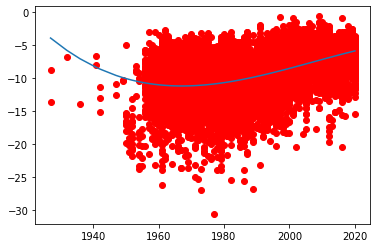

In [240]:
year = RBSongs['year']
loudness = RBSongs['loudness']
plt.plot(year, loudness, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, loudness, 3))(np.unique(year)))

In [223]:
AGRoots = influence[['influencer_name', 'follower_main_genre']]
AGRoots = AGRoots[AGRoots['follower_main_genre'] == 'Avant-Garde']
AGRoots = pd.DataFrame(AGroots['influencer_name'].value_counts(ascending=False))
AGRoots = AGRoots.reset_index()
AGRoots = AGRoots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of AG Followers'})
AGRoots

,Influencer,Number of AG Followers
0,John Cage,6
1,Terry Riley,3
2,Philip Glass,2
3,Moondog,2
4,Brian Eno,2
5,Harold Budd,1
6,Maria Callas,1
7,Funkadelic,1
8,John Cale,1
9,Giorgio Moroder,1


In [225]:
ELroots = influence[['influencer_name', 'follower_main_genre']]
ELroots = ELroots[ELroots['follower_main_genre'] == 'Easy Listening']
ELroots = pd.DataFrame(ELroots['influencer_name'].value_counts(ascending=False))
ELroots = ELroots.reset_index()
ELroots = ELroots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of EL Followers'})
ELroots

,Influencer,Number of EL Followers
0,Les Baxter,4
1,Liberace,3
2,Martin Denny,3
3,AntÃ´nio Carlos Jobim,2
4,Percy Faith,2
5,George Shearing,2
6,Paul Weston,1
7,Melissa Etheridge,1
8,Billy Joel,1
9,Mannheim Steamroller,1


In [233]:
jazzRoots = influence[['influencer_name', 'follower_main_genre']]
jazzRoots = jazzRoots[jazzRoots['follower_main_genre'] == 'Jazz']
jazzRoots = pd.DataFrame(jazzRoots['influencer_name'].value_counts(ascending=False))
jazzRoots = jazzRoots.reset_index()
jazzRoots = jazzRoots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of Jazz Followers'})
jazzAGoverlap = jazzRoots[jazzRoots['Influencer'].isin(AGRoots['Influencer'])]
jazzELoverlap = jazzRoots[jazzRoots['Influencer'].isin(ELroots['Influencer'])]
jazzELoverlap

,Influencer,Number of Jazz Followers
0,Miles Davis,83
19,Erroll Garner,18
29,Stan Getz,13
79,George Shearing,7
107,Milt Jackson,5
121,AntÃ´nio Carlos Jobim,5
137,JoÃ£o Gilberto,4
150,The Beatles,4
175,Frank Sinatra,3
179,Artie Shaw,3


In [399]:
def diffGen(name):
    df = artists[artists['artist_name'] == name]
    df = df.drop(['artist_name', 'artist_id', 'duration_ms', 'popularity', 'count', 'mode', 'key', 'liveness'], axis=1)
    df = pd.DataFrame(df.mean(axis=0))
    df = df.reset_index()
    df = df.rename(columns={'index': 'Characteristic', 0: 'Mean'})
    ID = artists.loc[artists['artist_name'] == name, 'artist_id']
    ID = list(ID)
    i = 0
    length = 0
    while length < 1:
        length = len(list(iGraph.successors(int(ID[i]))))
        if length > 0:
            break
        i += 1
    f = artists[artists['artist_id'].isin(list(iGraph.successors(int(ID[i]))))]
    f = f.drop(['artist_name', 'artist_id', 'duration_ms', 'popularity', 'count', 'mode', 'key', 'liveness'], axis=1)
    f = pd.DataFrame(f.mean(axis=0))
    f = f.reset_index()
    f = f.rename(columns={'index': 'Characteristic', 0: 'Mean'})
    df['Difference in %'] = abs((df['Mean'] - f['Mean'])/df['Mean']) * 100
    j = 0
    while i < len(df):
        if df['Difference in %'][i] == float('inf'):
            print('True')
            df.at[i, 'Difference in %'] = 100
        i += 1
    return df

In [400]:
jm = diffGen('Johnny Mandel')
jm

True


,Characteristic,Mean,Difference in %
0,danceability,0.596,21.105067
1,energy,0.225,30.159551
2,valence,0.490,20.078751
3,tempo,115.179,10.803519
4,loudness,-14.417,15.892817
5,acousticness,0.734,2.207741
6,instrumentalness,0.000,100.000000
7,speechiness,0.031,76.220692


In [401]:
average = diffGen('Miles Davis')
average['All Jazz'] = average['Difference in %']
for i in jazzRoots['Influencer']:
    print(i)
    df = diffGen(i)
    print(df)
    average['All Jazz'] = average['All Jazz'] + df['Difference in %']
average['All Jazz'] = average['All Jazz']/len(jazzRoots)
average

Miles Davis
     Characteristic        Mean  Difference in %
0      danceability    0.460221        10.526189
1            energy    0.308229        53.177014
2           valence    0.417860        20.194747
3             tempo  113.550382         0.528045
4          loudness  -14.526619         9.457358
5      acousticness    0.655711        25.706516
6  instrumentalness    0.205073        59.418083
7       speechiness    0.054571        15.638073
Charlie Parker
     Characteristic        Mean  Difference in %
0      danceability    0.492745         6.551321
1            energy    0.429547         4.825967
2           valence    0.618057        12.988605
3             tempo  117.159090         3.162469
4          loudness  -10.881240        24.965173
5      acousticness    0.797565        21.530788
6  instrumentalness    0.182118        64.498780
7       speechiness    0.078022         5.081028
John Coltrane
     Characteristic        Mean  Difference in %
0      danceability    0.460

7       speechiness    0.055478        23.137380
Ahmad Jamal
     Characteristic        Mean  Difference in %
0      danceability    0.590066        11.074321
1            energy    0.181912       100.852483
2           valence    0.424179         7.428334
3             tempo  103.816592         2.907713
4          loudness  -18.896105        14.927214
5      acousticness    0.840754        25.550986
6  instrumentalness    0.811226        52.224886
7       speechiness    0.044946         8.720253
Dexter Gordon
     Characteristic        Mean  Difference in %
0      danceability    0.503368         1.205620
1            energy    0.362061         5.720613
2           valence    0.549995         6.291541
3             tempo  115.542355         1.119793
4          loudness  -12.094368        14.235893
5      acousticness    0.747395        12.763671
6  instrumentalness    0.237022        11.737823
7       speechiness    0.048799         0.076450
George Benson
     Characteristic        Me

     Characteristic        Mean  Difference in %
0      danceability    0.401862        21.497099
1            energy    0.347137        10.353151
2           valence    0.363218        33.711173
3             tempo  108.967922         0.725811
4          loudness  -11.599353        23.314691
5      acousticness    0.791934        21.777189
6  instrumentalness    0.422614        20.025636
7       speechiness    0.050288        27.067377
Charles Mingus
     Characteristic        Mean  Difference in %
0      danceability    0.440410        16.436295
1            energy    0.302933        43.118047
2           valence    0.417417        17.727883
3             tempo  110.290904         5.786117
4          loudness  -15.562311        12.703349
5      acousticness    0.691750        23.332143
6  instrumentalness    0.238548        11.717294
7       speechiness    0.063169        15.460370
Jimmy Smith
     Characteristic        Mean  Difference in %
0      danceability    0.569104         2.

7       speechiness    0.077466        18.656859
Jackie McLean
     Characteristic        Mean  Difference in %
0      danceability    0.520429        12.448773
1            energy    0.455571         6.709563
2           valence    0.546286         6.980101
3             tempo  113.194143         0.601114
4          loudness  -12.297429         9.492431
5      acousticness    0.668286        19.451282
6  instrumentalness    0.146534       165.713822
7       speechiness    0.052271       117.530188
Ron Carter
     Characteristic        Mean  Difference in %
0      danceability    0.477286         6.494274
1            energy    0.245800        60.924193
2           valence    0.404400        14.475891
3             tempo  108.299857         2.825434
4          loudness  -18.905500        18.739541
5      acousticness    0.855643        25.370648
6  instrumentalness    0.655366        34.277612
7       speechiness    0.039436        24.429802
Louis Jordan
True
     Characteristic      M

7       speechiness    0.047900        50.811984
Cal Tjader
     Characteristic        Mean  Difference in %
0      danceability    0.600849         1.420567
1            energy    0.358786        34.276305
2           valence    0.681500         8.638065
3             tempo  115.844000         4.626469
4          loudness  -17.218103        31.646399
5      acousticness    0.826381        47.008400
6  instrumentalness    0.438550        29.985583
7       speechiness    0.046882         2.016939
Erskine Hawkins
     Characteristic      Mean  Difference in %
0      danceability    0.5750        18.137390
1            energy    0.1550       101.825270
2           valence    0.7660        41.121687
3             tempo  149.5130        25.022646
4          loudness  -15.2110         6.023958
5      acousticness    0.8900        18.238999
6  instrumentalness    0.3090        15.426325
7       speechiness    0.0512        19.508774
Ray Charles
     Characteristic        Mean  Difference in %

7       speechiness    0.075482        22.406449
Scott LaFaro
     Characteristic        Mean  Difference in %
0      danceability    0.518684        19.722307
1            energy    0.179316        59.839057
2           valence    0.378653         4.506005
3             tempo  103.801579         6.637573
4          loudness  -19.064158         3.679027
5      acousticness    0.845053        17.964798
6  instrumentalness    0.644788         4.079833
7       speechiness    0.043321         4.447818
Joe Henderson
     Characteristic        Mean  Difference in %
0      danceability    0.509632        20.382183
1            energy    0.435316         3.911037
2           valence    0.453484        25.324966
3             tempo  106.062632         0.040941
4          loudness  -11.083158        32.433842
5      acousticness    0.833316        40.907735
6  instrumentalness    0.402944        10.248302
7       speechiness    0.042063        89.744038
Art Pepper
     Characteristic        Mean

7       speechiness    0.051605         2.151046
Shelly Manne
     Characteristic       Mean  Difference in %
0      danceability   0.523450        16.638734
1            energy   0.131420       227.946948
2           valence   0.337500        22.472997
3             tempo  95.724300        10.033490
4          loudness -23.724950        32.462776
5      acousticness   0.835450        31.182288
6  instrumentalness   0.654119        22.988754
7       speechiness   0.050590         8.491917
Level 42
     Characteristic        Mean  Difference in %
0      danceability    0.711100        14.561216
1            energy    0.711300        33.984510
2           valence    0.757900        26.827889
3             tempo  110.147200        15.204047
4          loudness  -10.007700        20.405405
5      acousticness    0.189750       124.692949
6  instrumentalness    0.009844      4102.465555
7       speechiness    0.036880         1.067519
Cab Calloway
     Characteristic        Mean  Difference

     Characteristic        Mean  Difference in %
0      danceability    0.587200         2.708468
1            energy    0.395867         5.347367
2           valence    0.559200         3.287826
3             tempo  121.486800         3.106753
4          loudness  -14.728667         0.896280
5      acousticness    0.406520         2.630989
6  instrumentalness    0.616733        66.698608
7       speechiness    0.033993        31.512156
Wynton Marsalis
     Characteristic        Mean  Difference in %
0      danceability    0.448118         2.944905
1            energy    0.155953        79.358134
2           valence    0.325706        32.220181
3             tempo  108.744824        15.606992
4          loudness  -16.570118        27.878088
5      acousticness    0.840706        11.489345
6  instrumentalness    0.569071        10.552304
7       speechiness    0.039182        17.961267
Herb Alpert
     Characteristic        Mean  Difference in %
0      danceability    0.710739        25

7       speechiness    0.044860         3.567677
Andrew Hill
     Characteristic        Mean  Difference in %
0      danceability    0.434182        31.346184
1            energy    0.452545        20.479342
2           valence    0.476364        36.613812
3             tempo  123.426364        15.590977
4          loudness  -11.773364        11.237061
5      acousticness    0.679455        24.317969
6  instrumentalness    0.154424       155.021827
7       speechiness    0.055482        16.421944
Blood, Sweat & Tears
     Characteristic        Mean  Difference in %
0      danceability    0.439821        33.663877
1            energy    0.488786        24.314044
2           valence    0.494596        25.546572
3             tempo  100.080786        21.033558
4          loudness  -10.830000         8.115367
5      acousticness    0.447775        31.742692
6  instrumentalness    0.125461        64.133886
7       speechiness    0.061182        13.424870
Bobby Hackett
     Characteristic   

7       speechiness    0.040169        15.208568
Carmen McRae
     Characteristic        Mean  Difference in %
0      danceability    0.521623         3.392250
1            energy    0.229443        42.501039
2           valence    0.361925        16.063681
3             tempo  105.910755         9.238606
4          loudness  -12.361925         9.156562
5      acousticness    0.774868        17.007735
6  instrumentalness    0.000316     18431.697202
7       speechiness    0.053689         4.428261
Buddy Collette
     Characteristic        Mean  Difference in %
0      danceability    0.410583        11.223203
1            energy    0.153392       123.036763
2           valence    0.317917        38.618310
3             tempo  101.128833         7.360717
4          loudness  -19.183083        24.902669
5      acousticness    0.840667        14.456293
6  instrumentalness    0.627089        50.547589
7       speechiness    0.066742         2.754073
Marcos Valle
     Characteristic        M

7       speechiness    0.048100         8.038808
Earth, Wind & Fire
     Characteristic        Mean  Difference in %
0      danceability    0.600115        11.941758
1            energy    0.640871         2.663323
2           valence    0.687224         4.088082
3             tempo  118.141672         2.593205
4          loudness  -10.601187         6.639725
5      acousticness    0.328318        24.331438
6  instrumentalness    0.093426        12.000549
7       speechiness    0.050912        16.249301
Tuck & Patti
     Characteristic       Mean  Difference in %
0      danceability   0.537000         2.288346
1            energy   0.111800       215.969749
2           valence   0.295000        78.173238
3             tempo  94.635333        27.138967
4          loudness -16.930667        31.302442
5      acousticness   0.922333        35.765813
6  instrumentalness   0.000131    115964.558138
7       speechiness   0.053933         4.686567
Slam Stewart
     Characteristic     Mean  Dif

True
     Characteristic    Mean  Difference in %
0      danceability   0.616        11.725440
1            energy   0.209        42.717903
2           valence   0.346        41.036338
3             tempo  76.418        47.091117
4          loudness -16.566        10.839907
5      acousticness   0.966        21.830521
6  instrumentalness   0.000       100.000000
7       speechiness   0.902        93.341178
Wilbur Ware
     Characteristic        Mean  Difference in %
0      danceability    0.601444        26.427120
1            energy    0.286889        40.005810
2           valence    0.498667        46.758021
3             tempo  117.656111        19.664040
4          loudness  -14.690778        38.599424
5      acousticness    0.788333         8.763214
6  instrumentalness    0.217981       241.772571
7       speechiness    0.039989         9.634620
Howlin' Wolf
     Characteristic        Mean  Difference in %
0      danceability    0.590279        10.066151
1            energy    0.4

7       speechiness    0.03210        59.553193
Los Lobos
     Characteristic        Mean  Difference in %
0      danceability    0.567868        17.512122
1            energy    0.560447        27.027759
2           valence    0.789974         6.835511
3             tempo  137.999053        21.618686
4          loudness  -11.987895        33.742601
5      acousticness    0.300468        59.652828
6  instrumentalness    0.002386      2830.020059
7       speechiness    0.053445        92.898108
The Stanley Brothers
     Characteristic        Mean  Difference in %
0      danceability    0.566588         4.328349
1            energy    0.346500        38.910623
2           valence    0.599706         8.485714
3             tempo  128.297294         1.349157
4          loudness  -12.591118        10.550699
5      acousticness    0.539494         1.575931
6  instrumentalness    0.110983        29.610264
7       speechiness    0.036935        11.966878
Phoebe Snow
     Characteristic        

7       speechiness    0.041856        15.002464
Basia
     Characteristic        Mean  Difference in %
0      danceability    0.723375        19.289235
1            energy    0.543750        28.824565
2           valence    0.648750        41.334187
3             tempo  109.539375         0.146719
4          loudness  -12.847375         7.420529
5      acousticness    0.239950       122.974104
6  instrumentalness    0.003409       659.719555
7       speechiness    0.046637        34.710035
Ray Barretto
     Characteristic        Mean  Difference in %
0      danceability    0.633782         6.611847
1            energy    0.605333         1.424343
2           valence    0.852090         9.902459
3             tempo  112.249769         1.473503
4          loudness   -9.459577         4.117091
5      acousticness    0.545010        23.253605
6  instrumentalness    0.112844        19.767344
7       speechiness    0.057327         9.560757
John Coltrane Quartet
     Characteristic        M

7       speechiness    0.052444         0.018293
June Christy
     Characteristic        Mean  Difference in %
0      danceability    0.417803        27.367217
1            energy    0.202986        20.939312
2           valence    0.345033        26.699029
3             tempo  114.455364         2.913236
4          loudness  -11.667591        35.543112
5      acousticness    0.833758        12.725587
6  instrumentalness    0.017510        28.238318
7       speechiness    0.044547         2.810282
Ginger Baker
     Characteristic        Mean  Difference in %
0      danceability    0.578000        18.720070
1            energy    0.882000        14.915564
2           valence    0.761333        24.706411
3             tempo  113.576000        15.501853
4          loudness  -10.052000        10.916947
5      acousticness    0.303000        59.164405
6  instrumentalness    0.288334        12.474810
7       speechiness    0.086967        35.598835
Cachao
     Characteristic      Mean  Diffe

7       speechiness    0.043429         2.582238
Rosemary Clooney
     Characteristic        Mean  Difference in %
0      danceability    0.513194         3.876887
1            energy    0.277656        42.704990
2           valence    0.510040         7.005907
3             tempo  113.376290         1.852626
4          loudness  -12.760054         9.852923
5      acousticness    0.883161        25.805187
6  instrumentalness    0.020884        32.219643
7       speechiness    0.059719         2.373448
Robert Plant
     Characteristic        Mean  Difference in %
0      danceability    0.524955         1.033998
1            energy    0.709568        14.026778
2           valence    0.429023        25.403217
3             tempo  133.135046        10.483608
4          loudness   -7.377523        30.097066
5      acousticness    0.170878        52.844332
6  instrumentalness    0.054098        39.857775
7       speechiness    0.046691        65.859547
Bobby Darin
     Characteristic        

     Characteristic       Mean  Difference in %
0      danceability    0.61900        16.556722
1            energy    0.83900        53.455006
2           valence    0.74300        26.299163
3             tempo  162.38500        30.284971
4          loudness  -10.20400        26.472870
5      acousticness    0.26500       122.271803
6  instrumentalness    0.00363      3938.564339
7       speechiness    0.41600        85.634682
Bebo ValdÃ©s
     Characteristic     Mean  Difference in %
0      danceability   0.6380         2.351097
1            energy   0.6750         4.691358
2           valence   0.7150        22.610723
3             tempo  99.9920         6.750540
4          loudness  -7.8870         1.673640
5      acousticness   0.8820        50.263965
6  instrumentalness   0.6930         0.817701
7       speechiness   0.0592        35.641892
Bill Doggett
     Characteristic        Mean  Difference in %
0      danceability    0.603000         6.122745
1            energy    0.58866

7       speechiness    0.559000     9.409899e+01
Bobby Short
     Characteristic        Mean  Difference in %
0      danceability    0.521000        12.466411
1            energy    0.282500         1.032448
2           valence    0.531000        36.296296
3             tempo  118.772000         6.837709
4          loudness  -15.849500        17.148490
5      acousticness    0.756000         3.511905
6  instrumentalness    0.002466       499.410473
7       speechiness    0.165550        74.031008
Danny Thompson
     Characteristic        Mean  Difference in %
0      danceability    0.463000     2.003240e+01
1            energy    0.154000     3.896104e+02
2           valence    0.319000     4.235110e+01
3             tempo  137.325000     1.609360e+01
4          loudness  -13.922000     2.142263e+01
5      acousticness    0.854000     8.710694e+01
6  instrumentalness    0.000001     6.237603e+07
7       speechiness    0.036400     1.265911e+02
Phish
     Characteristic        Mean  Dif

7       speechiness    0.060607        29.342149
Sonny Clark
     Characteristic        Mean  Difference in %
0      danceability    0.528214         8.326572
1            energy    0.344979        34.476520
2           valence    0.573964        37.836538
3             tempo  118.431071        12.426671
4          loudness  -14.513464        23.240587
5      acousticness    0.851536         3.247913
6  instrumentalness    0.403908        57.138925
7       speechiness    0.046954         8.233817
Michael Henderson
     Characteristic       Mean  Difference in %
0      danceability   0.646400        11.623608
1            energy   0.571000        22.789901
2           valence   0.492200        22.702357
3             tempo  95.287000         8.451370
4          loudness  -9.563200        40.321406
5      acousticness   0.132324        49.472338
6  instrumentalness   0.004853       572.789419
7       speechiness   0.082660        25.192153
Noel Redding
     Characteristic       Mean  Dif

     Characteristic        Mean  Difference in %
0      danceability    0.561333         7.185903
1            energy    0.430000        26.750822
2           valence    0.509500         0.177685
3             tempo  113.961333        13.311999
4          loudness  -11.477667        23.590110
5      acousticness    0.606167        49.747559
6  instrumentalness    0.006345       776.440698
7       speechiness    0.041150         2.284940
Idris Muhammad
     Characteristic        Mean  Difference in %
0      danceability    0.643636         3.474576
1            energy    0.641455         2.409297
2           valence    0.673636        42.510121
3             tempo  125.334454        19.718803
4          loudness   -8.650545         0.976292
5      acousticness    0.232252        21.636781
6  instrumentalness    0.433197       101.524984
7       speechiness    0.062391        36.048375
Abbey Lincoln
     Characteristic       Mean  Difference in %
0      danceability   0.447714        19.

7       speechiness    0.038111         9.927031
Helen Merrill
     Characteristic        Mean  Difference in %
0      danceability    0.363600        43.286024
1            energy    0.144253        88.077822
2           valence    0.270233        70.352065
3             tempo  113.413100         4.579417
4          loudness  -17.453233        10.256252
5      acousticness    0.896433        20.201462
6  instrumentalness    0.009522       125.245920
7       speechiness    0.040297        20.962838
Miriam Makeba
     Characteristic        Mean  Difference in %
0      danceability    0.497233        23.387614
1            energy    0.176870       153.130003
2           valence    0.574698         0.241560
3             tempo  118.370512         3.839690
4          loudness  -15.273860        19.262568
5      acousticness    0.867256        41.849434
6  instrumentalness    0.000018    469223.575000
7       speechiness    0.075991        15.282011
Maynard Ferguson
     Characteristic     

,Characteristic,Mean,Difference in %,All Jazz
0,danceability,0.460221,10.526189,17.572490
1,energy,0.308229,53.177014,62.175926
2,valence,0.417860,20.194747,34.530507
3,tempo,113.550382,0.528045,10.050108
4,loudness,-14.526619,9.457358,21.005121
5,acousticness,0.655711,25.706516,298.464444
6,instrumentalness,0.205073,59.418083,207186.178870
7,speechiness,0.054571,15.638073,36.265284
